In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [ ]:
df_train = pd.read_csv("train.csv")
df_train.head(10)

,Review,Type
0,মা মেয়ের একটি সকাল.আড্ডা আর মজার নাস্তা.আজ আম...,very good
1,আমি ফুডপান্ডায় অর্ডার দিলাম এবং খাবার দেখে আম...,bad
2,বৃষ্টির দিনে স্ট্রিটফুড খেতে কার না ভালো লাগে ...,very good
3,আজকে এই প্রথমবার জিনজিরা ফেরিঘাট থেকে আসার পথে...,very good
4,পছন্দের রেস্টুরেন্ট এর মধ্যে একটা হলো Chicken...,very good
5,শহরের সেরা বাফেটের সেরা অফার.মিস করলেই হবে লস্...,very good
6,যারা Kabab lovers আছে তাদের জন্য Unlimited Kab...,very good
7,বিদেশী অক্টোপাস ৩০০ ফিট ১০০০/৯০০০৳ হাজার টাকার...,good
8,ধানমন্ডির মধ্যে সেরা এক নাম্বার বাজে বুফে the ...,bad
9,মিড রেঞ্জের মধ্যে পয়সাউসুল প্রিমিয়াম একটি ব্যু...,very good


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os

# Disable tokenizers parallelism to avoid the warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.1.0+cu121
transformers: 4.35.2



In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
df_test = pd.read_csv("test.csv")
df_test.head(10)

,Review,Type
0,"American Chopsuey অত্যন্ত বাজে ছিলো,মুখে নেওয়া...",bad
1,Un ভাইয়ের positive Review dekhe : ছেলেকে নিয়...,bad
2,গার্লিক নানের ডিফারেন্স বুঝতে পারিনি। ইন্ডিয়ান...,good
3,এটা আমার করা ১৭ নং বাফেট। ট্রাষ্ট মি এতো বাজে ...,bad
4,"Pour nous, le bouffé a commencé environ 20/25 ...",bad
5,বৃষ্টির মাঝে Foodshahi হোম ডেলিভারি সার্ভিসের ...,very good
6,এবার আসি খাবারের বিষয়ে শরমাতে মাংসের পরিমান ভা...,good
7,অসাধারণ একটা ফ্লেভার ছিল এই বিরিয়ানিতে পেঁয়া...,very good
8,"অনেকদিন পরে শ্যাভেজর সরমা, এলিয়েন সাব আর তাদের...",good
9,"মেইন কোর্সে ছিলো কাচ্চি, বীফ রেজালা, চিকেন টিক...",good


In [42]:
df_val = pd.read_csv("val1.csv")
df_val.head(10)

,Review,Type
0,পিজাটা চমৎকার ছিল । আমি এবং আমার বন্ধুদের এটি ...,1
1,পিজাটা চমৎকার ছিল । আমি এবং আমার বন্ধুদের এটি ...,1
2,এরাবিয়ান মাস্টারের অভ্যন্তরীণ সজ্জাটা অনন্য। ...,1
3,কোরিয়ান এবং জামাইকান BBQ উপভোগ করার জন্য একটি...,1
4,BBQ এর মেনুগুলো সেরা।,1
5,শ্রেষ্ঠ স্বাদ ..... খাবারের মানও ভাল ....,1
6,সেরা পরিবেশ সঙ্গে শ্রেষ্ঠ স্বাদ। একেবারে প্রিম...,1
7,সত্যিই খেতে দারুণ টেস্ট !!! আমি শুধু BBQ ভালব...,1
8,মহান খাদ্য বাহ ভাল বাহ সঙ্গে মহান সেবা ..........,1
9,অসাধারণ এবং সুস্বাদু খাদ্য ... ভাল সার্ভিস এবং...,1


In [ ]:
df_train=df_train.dropna()
df_test=df_test.dropna()
df_val=df_val.dropna()

# Data Exploration

In [ ]:
df_train.head(10)

,Review,Type
0,মা মেয়ের একটি সকাল.আড্ডা আর মজার নাস্তা.আজ আম...,very good
1,আমি ফুডপান্ডায় অর্ডার দিলাম এবং খাবার দেখে আম...,bad
2,বৃষ্টির দিনে স্ট্রিটফুড খেতে কার না ভালো লাগে ...,very good
3,আজকে এই প্রথমবার জিনজিরা ফেরিঘাট থেকে আসার পথে...,very good
4,পছন্দের রেস্টুরেন্ট এর মধ্যে একটা হলো Chicken...,very good
5,শহরের সেরা বাফেটের সেরা অফার.মিস করলেই হবে লস্...,very good
6,যারা Kabab lovers আছে তাদের জন্য Unlimited Kab...,very good
7,বিদেশী অক্টোপাস ৩০০ ফিট ১০০০/৯০০০৳ হাজার টাকার...,good
8,ধানমন্ডির মধ্যে সেরা এক নাম্বার বাজে বুফে the ...,bad
9,মিড রেঞ্জের মধ্যে পয়সাউসুল প্রিমিয়াম একটি ব্যু...,very good


# Label 0, 1 or 2 . '0' for neutral, '1' for positive and '2' for negative

In [ ]:
mapping = {'bad': 0, 'good': 1, 'very good': 2}

In [ ]:
df_train['Type'] = df_train['Type'].map(mapping)

In [ ]:
df_train

,Review,Type
0,মা মেয়ের একটি সকাল.আড্ডা আর মজার নাস্তা.আজ আম...,2
1,আমি ফুডপান্ডায় অর্ডার দিলাম এবং খাবার দেখে আম...,0
2,বৃষ্টির দিনে স্ট্রিটফুড খেতে কার না ভালো লাগে ...,2
3,আজকে এই প্রথমবার জিনজিরা ফেরিঘাট থেকে আসার পথে...,2
4,পছন্দের রেস্টুরেন্ট এর মধ্যে একটা হলো Chicken...,2
...,...,...
109,"মেইন কোর্সে ছিলো খিচুড়ি, খাসির বিরিয়ানি, বীফ র...",1
110,বেশ অনেকদিন থেকেই যাওয়ার ইচ্ছা ছিলো। এট লাস্ট ...,1
111,রিফিলের অবস্থা খুবই বাজে।ব্যুফের সময় ১:০০ টা ব...,0
112,The Pan Pacific Lounge এ গতকাল একটি নেগেটিভ রি...,0


In [ ]:
map = {'bad': 0, 'good': 1, 'very good': 2}
df_test['Type'] = df_test['Type'].map(map)
df_test

,Review,Type
0,"American Chopsuey অত্যন্ত বাজে ছিলো,মুখে নেওয়া...",0
1,Un ভাইয়ের positive Review dekhe : ছেলেকে নিয়...,0
2,গার্লিক নানের ডিফারেন্স বুঝতে পারিনি। ইন্ডিয়ান...,1
3,এটা আমার করা ১৭ নং বাফেট। ট্রাষ্ট মি এতো বাজে ...,0
4,"Pour nous, le bouffé a commencé environ 20/25 ...",0
5,বৃষ্টির মাঝে Foodshahi হোম ডেলিভারি সার্ভিসের ...,2
6,এবার আসি খাবারের বিষয়ে শরমাতে মাংসের পরিমান ভা...,1
7,অসাধারণ একটা ফ্লেভার ছিল এই বিরিয়ানিতে পেঁয়া...,2
8,"অনেকদিন পরে শ্যাভেজর সরমা, এলিয়েন সাব আর তাদের...",1
9,"মেইন কোর্সে ছিলো কাচ্চি, বীফ রেজালা, চিকেন টিক...",1


In [41]:
mapl = {'bad': 0, 'good': 1, 'very good': 2}
df_val['Type'] = df_val['Type'].map(mapl)
df_val

,Review,Type
0,পিজাটা চমৎকার ছিল । আমি এবং আমার বন্ধুদের এটি ...,NaN
1,পিজাটা চমৎকার ছিল । আমি এবং আমার বন্ধুদের এটি ...,NaN
2,এরাবিয়ান মাস্টারের অভ্যন্তরীণ সজ্জাটা অনন্য। ...,NaN
3,কোরিয়ান এবং জামাইকান BBQ উপভোগ করার জন্য একটি...,NaN
4,BBQ এর মেনুগুলো সেরা।,NaN
5,শ্রেষ্ঠ স্বাদ ..... খাবারের মানও ভাল ....,NaN
6,সেরা পরিবেশ সঙ্গে শ্রেষ্ঠ স্বাদ। একেবারে প্রিম...,NaN
7,সত্যিই খেতে দারুণ টেস্ট !!! আমি শুধু BBQ ভালব...,NaN
8,মহান খাদ্য বাহ ভাল বাহ সঙ্গে মহান সেবা ..........,NaN
9,অসাধারণ এবং সুস্বাদু খাদ্য ... ভাল সার্ভিস এবং...,NaN


In [43]:
df_train['Type'].value_counts()

2    59
1    39
0    16
Name: Type, dtype: int64

In [44]:
df_test['Type'].value_counts()

0    4
1    4
2    2
Name: Type, dtype: int64

In [45]:
df_val['Type'].value_counts()

1    29
0    23
2     3
Name: Type, dtype: int64

In [ ]:
df_train.shape

(114, 2)

In [ ]:
df_train[:]

,Review,Type
0,মা মেয়ের একটি সকাল.আড্ডা আর মজার নাস্তা.আজ আম...,2
1,আমি ফুডপান্ডায় অর্ডার দিলাম এবং খাবার দেখে আম...,0
2,বৃষ্টির দিনে স্ট্রিটফুড খেতে কার না ভালো লাগে ...,2
3,আজকে এই প্রথমবার জিনজিরা ফেরিঘাট থেকে আসার পথে...,2
4,পছন্দের রেস্টুরেন্ট এর মধ্যে একটা হলো Chicken...,2
...,...,...
109,"মেইন কোর্সে ছিলো খিচুড়ি, খাসির বিরিয়ানি, বীফ র...",1
110,বেশ অনেকদিন থেকেই যাওয়ার ইচ্ছা ছিলো। এট লাস্ট ...,1
111,রিফিলের অবস্থা খুবই বাজে।ব্যুফের সময় ১:০০ টা ব...,0
112,The Pan Pacific Lounge এ গতকাল একটি নেগেটিভ রি...,0


In [ ]:
df_train['Type'].value_counts()

2    59
1    39
0    16
Name: Type, dtype: int64

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  114 non-null    object
 1   Type    114 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.9+ KB


In [46]:
class_names = ['bad', 'good','very good']

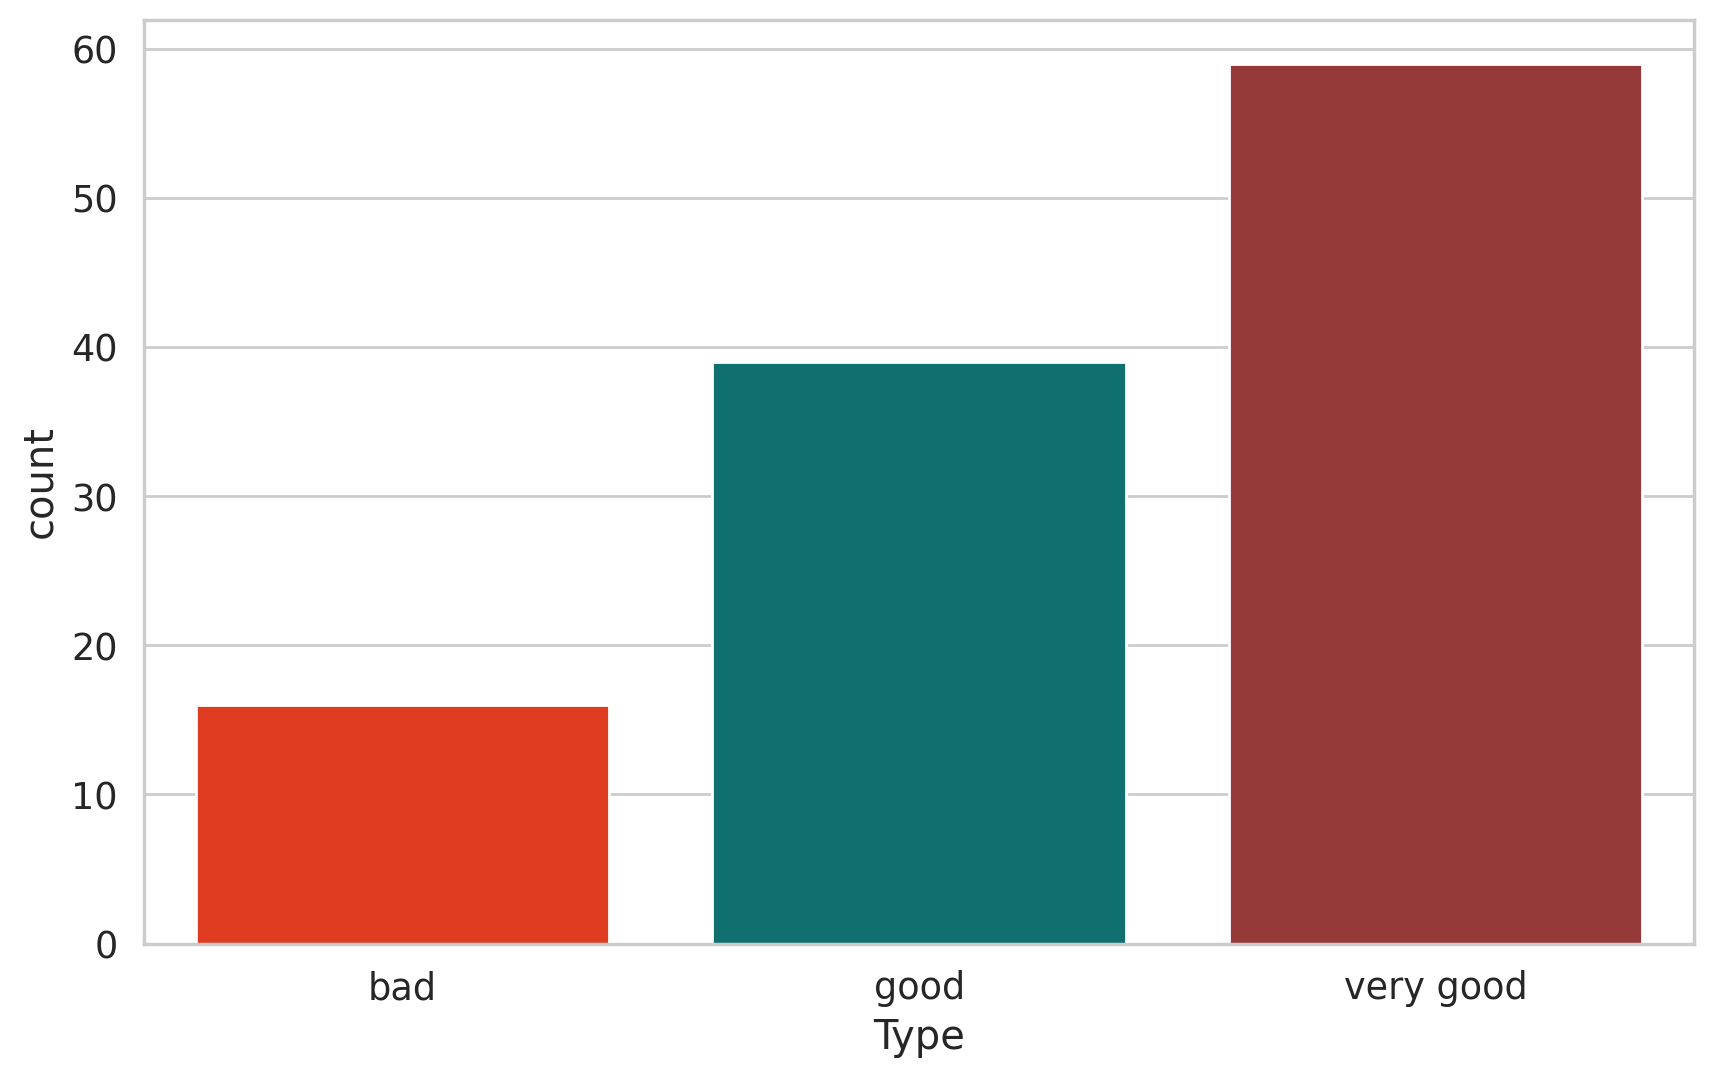

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(10, 6))

Toxic_count = df_train['Type'].value_counts()
#sns.countplot(x='Score', data=df, order=Toxic_count.index)
#sns.countplot(x='Score', data=df, order=Toxic_count.index, color='blue')
sns.countplot(x='Type', data=df_train, palette=['#FF2400', 'teal','#A52A2A','Seagreen'])
# Rename the x-axis tick labels
new_labels = class_names# Replace with your desired labels
plt.gca().set_xticklabels(new_labels)

plt.show()

In [48]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [49]:
PRE_TRAINED_MODEL_NAME = 'csebuetnlp/banglabert'

In [50]:
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [51]:
pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-lb4jug04
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-lb4jug04
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6859 sha256=efce68e59d9f780952e40cb6d22a021b4e2d6a087657ef013e882ff73e18b885
  Stored in directory: /tmp/pip-ephem-wheel-cache-l379meb0/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186460 sha256=1d2e0f37378a69339145627953aee673226e94

In [52]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from normalizer import normalize # pip install git+https://github.com/csebuetnlp/normalizer
import torch

In [53]:
sample_txt= "আমি কৃতজ্ঞ কারণ আপনি আমার জন্য অনেক কিছু করেছেন।"

In [54]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

# Choosing Sequence Length

In [56]:
token_lens = []

for txt in df_train.Review:
  txt = normalize(txt) # this normalization step is required before tokenizing the text
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


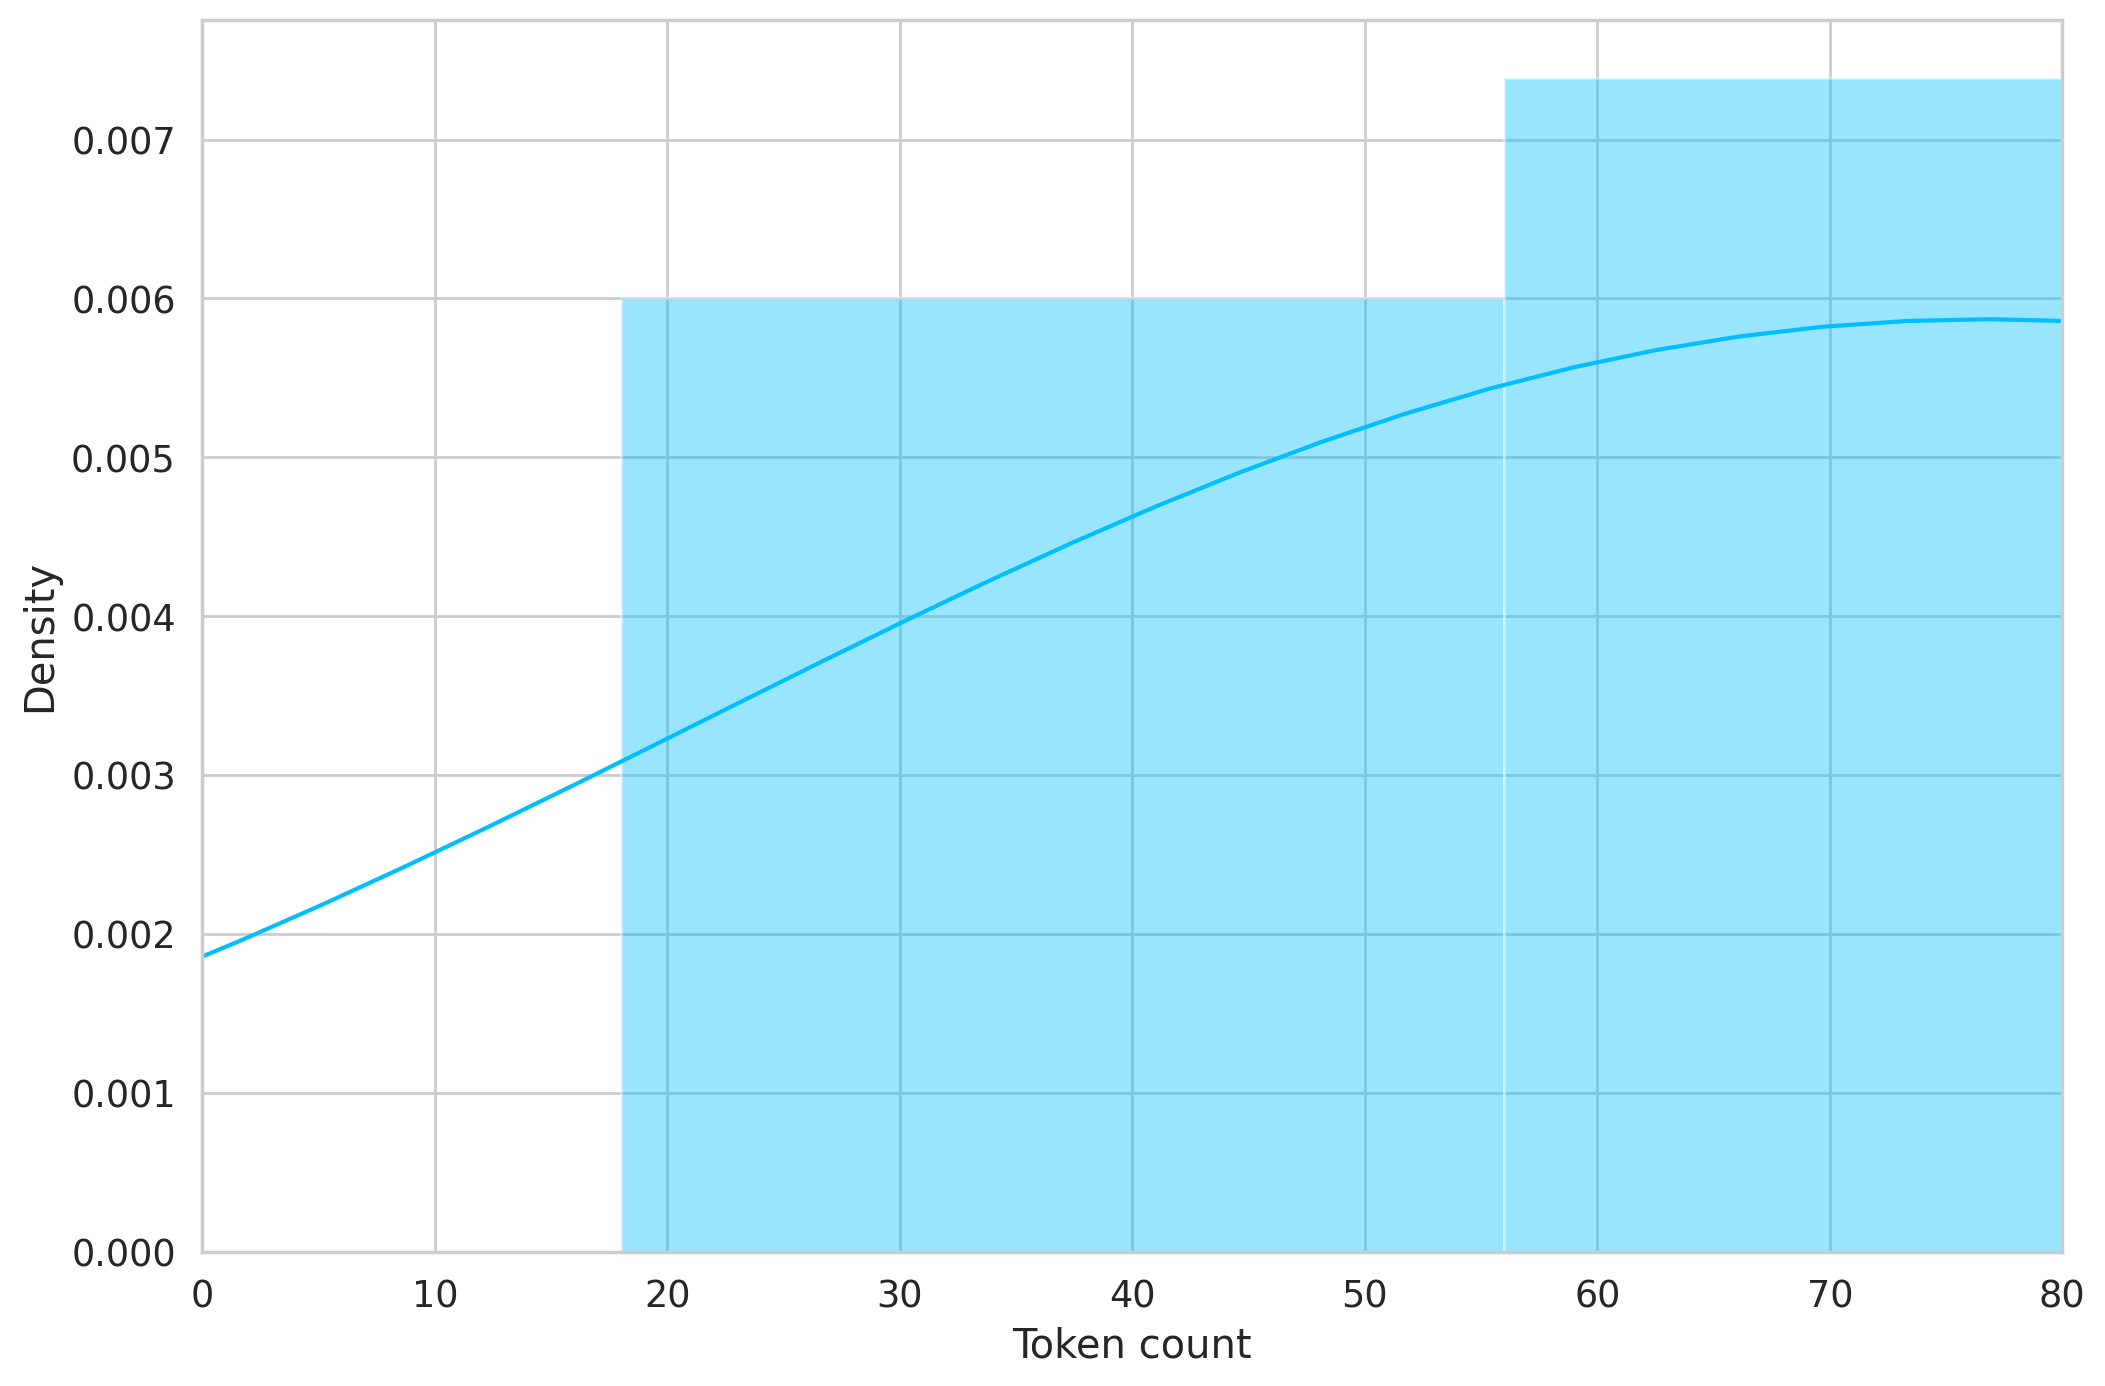

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 80]);
plt.xlabel('Token count');

In [57]:
MAX_LEN = 80

In [58]:
class GPReviewDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    review = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'Data': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [59]:
df_train.shape, df_val.shape, df_test.shape

((114, 2), (55, 2), (10, 2))

In [60]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    comments=df.Review.to_numpy(),
    targets=df.Type.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [61]:
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [62]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['Data', 'input_ids', 'attention_mask', 'targets'])

In [63]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([64, 80])
torch.Size([64, 80])
torch.Size([64])


In [64]:
bert_model = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME)

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [65]:
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [66]:
torch.cuda.empty_cache()

In [67]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [68]:
PRE_TRAINED_MODEL_NAME

'csebuetnlp/banglabert'

In [69]:
bert_model.config.hidden_size

768

In [70]:
last_hidden_state

ElectraForPreTrainingOutput(loss=None, logits=tensor([[-14.3940,  -4.4122,  -4.3277,  -3.2799,  -1.9589,  -5.0296,  -4.4236,
          -3.4212,  -2.1917,  -3.7347,  -4.1613, -14.3940,   3.5824,   2.7211,
           3.2464,   2.1568,   2.1993,   1.0031,   1.8768,   1.0918,   0.1768,
           1.5221,   3.9135,   2.8866,   2.2538,   1.7030, -12.2174,   4.5514,
          -0.4338,   0.7459,  -0.3823,   1.3115]], grad_fn=<SqueezeBackward1>), hidden_states=None, attentions=None)

In [71]:
class sentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(sentimentClassifier, self).__init__()
        self.electra = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(80, n_classes)  # Adjust the input size

    def forward(self, input_ids, attention_mask):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        pooled_output = outputs.logits  # Access logits for pooled output
        output = self.drop(pooled_output)
        return self.out(output)

In [72]:
model = sentimentClassifier(len(class_names))
model = model.to(device)

In [73]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([64, 80])
torch.Size([64, 80])


In [74]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[5.9565e-01, 2.2863e-01, 1.7572e-01],
        [9.0071e-01, 5.7794e-02, 4.1494e-02],
        [3.1710e-01, 4.9849e-01, 1.8441e-01],
        [4.3487e-03, 8.2624e-02, 9.1303e-01],
        [7.2030e-01, 2.1073e-03, 2.7759e-01],
        [8.6641e-01, 1.6637e-02, 1.1695e-01],
        [9.9374e-01, 4.1890e-03, 2.0737e-03],
        [5.0049e-01, 4.9160e-01, 7.9099e-03],
        [5.1229e-02, 9.7548e-03, 9.3902e-01],
        [8.5239e-01, 6.0409e-02, 8.7203e-02],
        [7.6832e-01, 2.0935e-01, 2.2328e-02],
        [9.9354e-01, 5.6568e-03, 7.9907e-04],
        [8.9531e-01, 9.0020e-02, 1.4673e-02],
        [7.0050e-02, 1.5860e-01, 7.7135e-01],
        [8.9620e-01, 9.1565e-02, 1.2236e-02],
        [8.7835e-01, 2.3906e-02, 9.7742e-02],
        [7.0530e-01, 1.5450e-01, 1.4020e-01],
        [9.9706e-01, 1.7517e-03, 1.1842e-03],
        [5.1654e-03, 2.0700e-03, 9.9276e-01],
        [7.7514e-01, 1.1514e-02, 2.1335e-01],
        [7.7399e-01, 2.1417e-01, 1.1840e-02],
        [1.4953e-02, 1.0526e-01, 8

In [ ]:
training

In [75]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [76]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  #tqdm for progress monitoring
  data_loader = tqdm(data_loader, desc="Training", unit="batch")

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    # Update tqdm description with the current loss
    data_loader.set_postfix(loss=np.mean(losses))

  return correct_predictions.double() / n_examples, np.mean(losses)

In [77]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0


    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [78]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'\nTrain loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'\nVal   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


Training: 100%|██████████| 2/2 [00:03<00:00,  1.56s/batch, loss=2.79]



Train loss 2.7924381494522095 accuracy 0.27192982456140347


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.79batch/s, loss=3.49]



Val   loss 3.493865489959717 accuracy 0.34545454545454546

Epoch 2/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.12batch/s, loss=2.47]



Train loss 2.465466022491455 accuracy 0.22807017543859648


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.57batch/s, loss=2.7]



Val   loss 2.697315216064453 accuracy 0.3090909090909091

Epoch 3/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.15batch/s, loss=2.06]



Train loss 2.0554304122924805 accuracy 0.3508771929824561


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.08batch/s, loss=2.14]



Val   loss 2.136601448059082 accuracy 0.2727272727272727

Epoch 4/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.24batch/s, loss=1.68]



Train loss 1.6778181195259094 accuracy 0.4298245614035088


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.00batch/s, loss=1.81]



Val   loss 1.8056130409240723 accuracy 0.39999999999999997

Epoch 5/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.14batch/s, loss=1.39]



Train loss 1.3946049809455872 accuracy 0.49122807017543857


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.07batch/s, loss=1.57]



Val   loss 1.5688267946243286 accuracy 0.5272727272727272

Epoch 6/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.18batch/s, loss=1.21]



Train loss 1.2064290940761566 accuracy 0.5


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.22batch/s, loss=1.38]



Val   loss 1.3798761367797852 accuracy 0.5272727272727272

Epoch 7/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.23batch/s, loss=1.24]



Train loss 1.235961377620697 accuracy 0.5


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.19batch/s, loss=1.23]



Val   loss 1.2348307371139526 accuracy 0.5272727272727272

Epoch 8/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.19batch/s, loss=1.04]



Train loss 1.0403213798999786 accuracy 0.587719298245614


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.65batch/s, loss=1.16]



Val   loss 1.1637991666793823 accuracy 0.5272727272727272

Epoch 9/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.16batch/s, loss=0.952]



Train loss 0.9516645669937134 accuracy 0.5526315789473684


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.19batch/s, loss=1.12]



Val   loss 1.117211103439331 accuracy 0.5454545454545454

Epoch 10/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.22batch/s, loss=0.771]



Train loss 0.7714210152626038 accuracy 0.6754385964912281


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.17batch/s, loss=1.1]



Val   loss 1.1049143075942993 accuracy 0.5454545454545454

Epoch 11/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.23batch/s, loss=1.08]



Train loss 1.0824552774429321 accuracy 0.5263157894736842


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.20batch/s, loss=1.09]



Val   loss 1.0866011381149292 accuracy 0.5272727272727272

Epoch 12/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.23batch/s, loss=0.923]



Train loss 0.923096239566803 accuracy 0.5614035087719298


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.21batch/s, loss=1.09]



Val   loss 1.0895057916641235 accuracy 0.5272727272727272

Epoch 13/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.19batch/s, loss=0.748]



Train loss 0.7479719519615173 accuracy 0.6578947368421052


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.58batch/s, loss=1.11]



Val   loss 1.1098592281341553 accuracy 0.509090909090909

Epoch 14/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.14batch/s, loss=0.653]



Train loss 0.6525714993476868 accuracy 0.7017543859649122


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.15batch/s, loss=1.13]



Val   loss 1.130420446395874 accuracy 0.4909090909090909

Epoch 15/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.12batch/s, loss=0.704]



Train loss 0.7038821578025818 accuracy 0.7017543859649122


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.31batch/s, loss=1.15]



Val   loss 1.1470149755477905 accuracy 0.4727272727272727

Epoch 16/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.19batch/s, loss=0.588]



Train loss 0.5877838432788849 accuracy 0.7280701754385964


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.12batch/s, loss=1.16]



Val   loss 1.155700922012329 accuracy 0.45454545454545453

Epoch 17/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.21batch/s, loss=0.592]



Train loss 0.5920495092868805 accuracy 0.7280701754385964


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.09batch/s, loss=1.17]



Val   loss 1.1651493310928345 accuracy 0.4727272727272727

Epoch 18/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.17batch/s, loss=0.587]



Train loss 0.5872730016708374 accuracy 0.7719298245614035


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.68batch/s, loss=1.18]



Val   loss 1.1768163442611694 accuracy 0.4909090909090909

Epoch 19/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.13batch/s, loss=0.53]



Train loss 0.5298864543437958 accuracy 0.7894736842105263


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.17batch/s, loss=1.18]



Val   loss 1.1839274168014526 accuracy 0.4909090909090909

Epoch 20/20
----------


Training: 100%|██████████| 2/2 [00:01<00:00,  1.21batch/s, loss=0.586]



Train loss 0.58587846159935 accuracy 0.7807017543859649


Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.01batch/s, loss=1.19]


Val   loss 1.186143398284912 accuracy 0.509090909090909

CPU times: user 23.7 s, sys: 17 s, total: 40.7 s
Wall time: 53 s


In [79]:
model=sentimentClassifier(len(class_names))

In [80]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [81]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.23batch/s, loss=1.18]


0.5

In [82]:
def get_predictions(model, data_loader):
  model = model.eval()

  toxic_comments = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["Data"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      toxic_comments.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return toxic_comments, predictions, prediction_probs, real_values

In [83]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [84]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

              precision    recall  f1-score   support

         bad     0.6000    0.7500    0.6667         4
        good     0.5000    0.5000    0.5000         4
   very good     0.0000    0.0000    0.0000         2

    accuracy                         0.5000        10
   macro avg     0.3667    0.4167    0.3889        10
weighted avg     0.4400    0.5000    0.4667        10



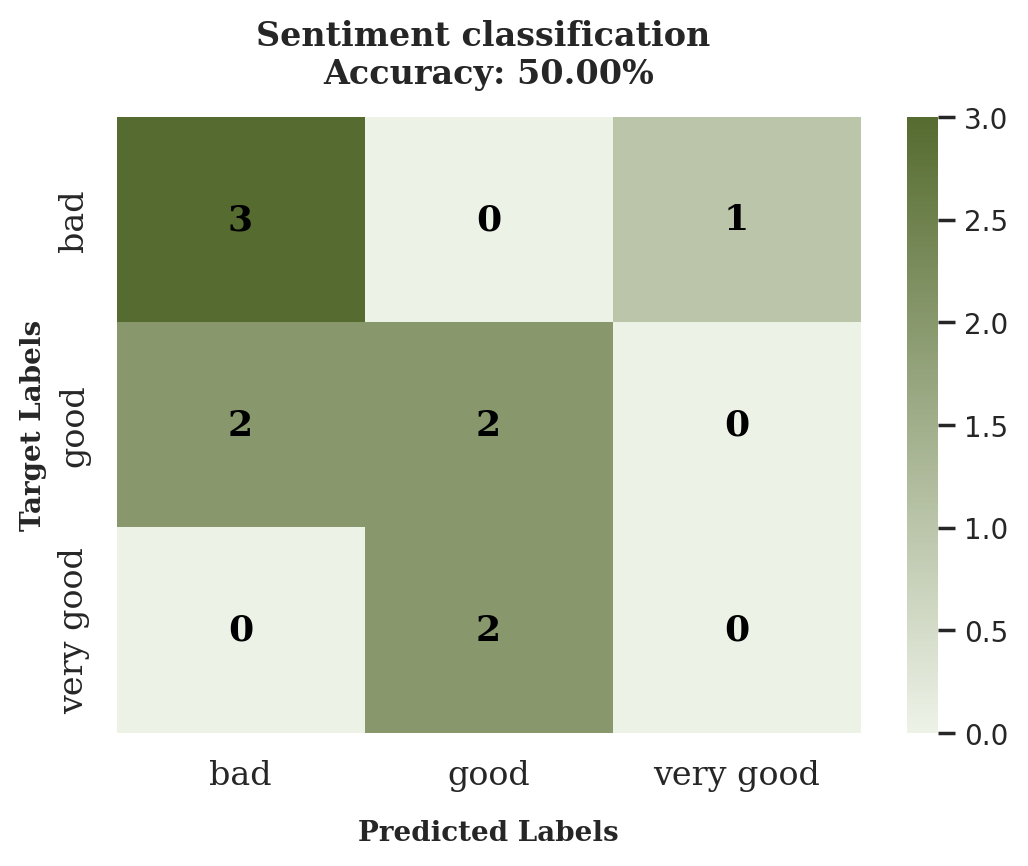

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.light_palette("DarkOliveGreen", as_cmap=True)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=class_names, yticklabels=class_names,
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)
heatmap.set_title('Sentiment classification \nAccuracy: {:.2f}%'.format(accuracy_percentage),
                  fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()

In [87]:
idx = 5

review_text = y_review_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [88]:
print("\n".join(wrap(review_text)))
print()
print(f'True Label: {class_names[true_label]}')

মেইন কোর্সে ছিলো কাচ্চি, বীফ রেজালা, চিকেন টিক্কা বাটার মাসালা,
ফ্লেমিং চিকেন,চিলি চিকেন, বীফ চিলি, প্রণ মাসালা, ভেজিটেবল দোপেয়াজা,
ফ্রাইড রাইস, চিকেন বিরিয়ানী, বম যেসব আইটেম ছিলো তার মধ্যে বীফ রেজালা,
বীফ চিলি,চিকেন টিক্কা বাটার মাসালা,ফ্লেমিং চিকেন,প্রণ মাসালা, চিকেন
বিরয়ানি.. এই আইটেমগুলো ভালো লাগছে।

True Label: good


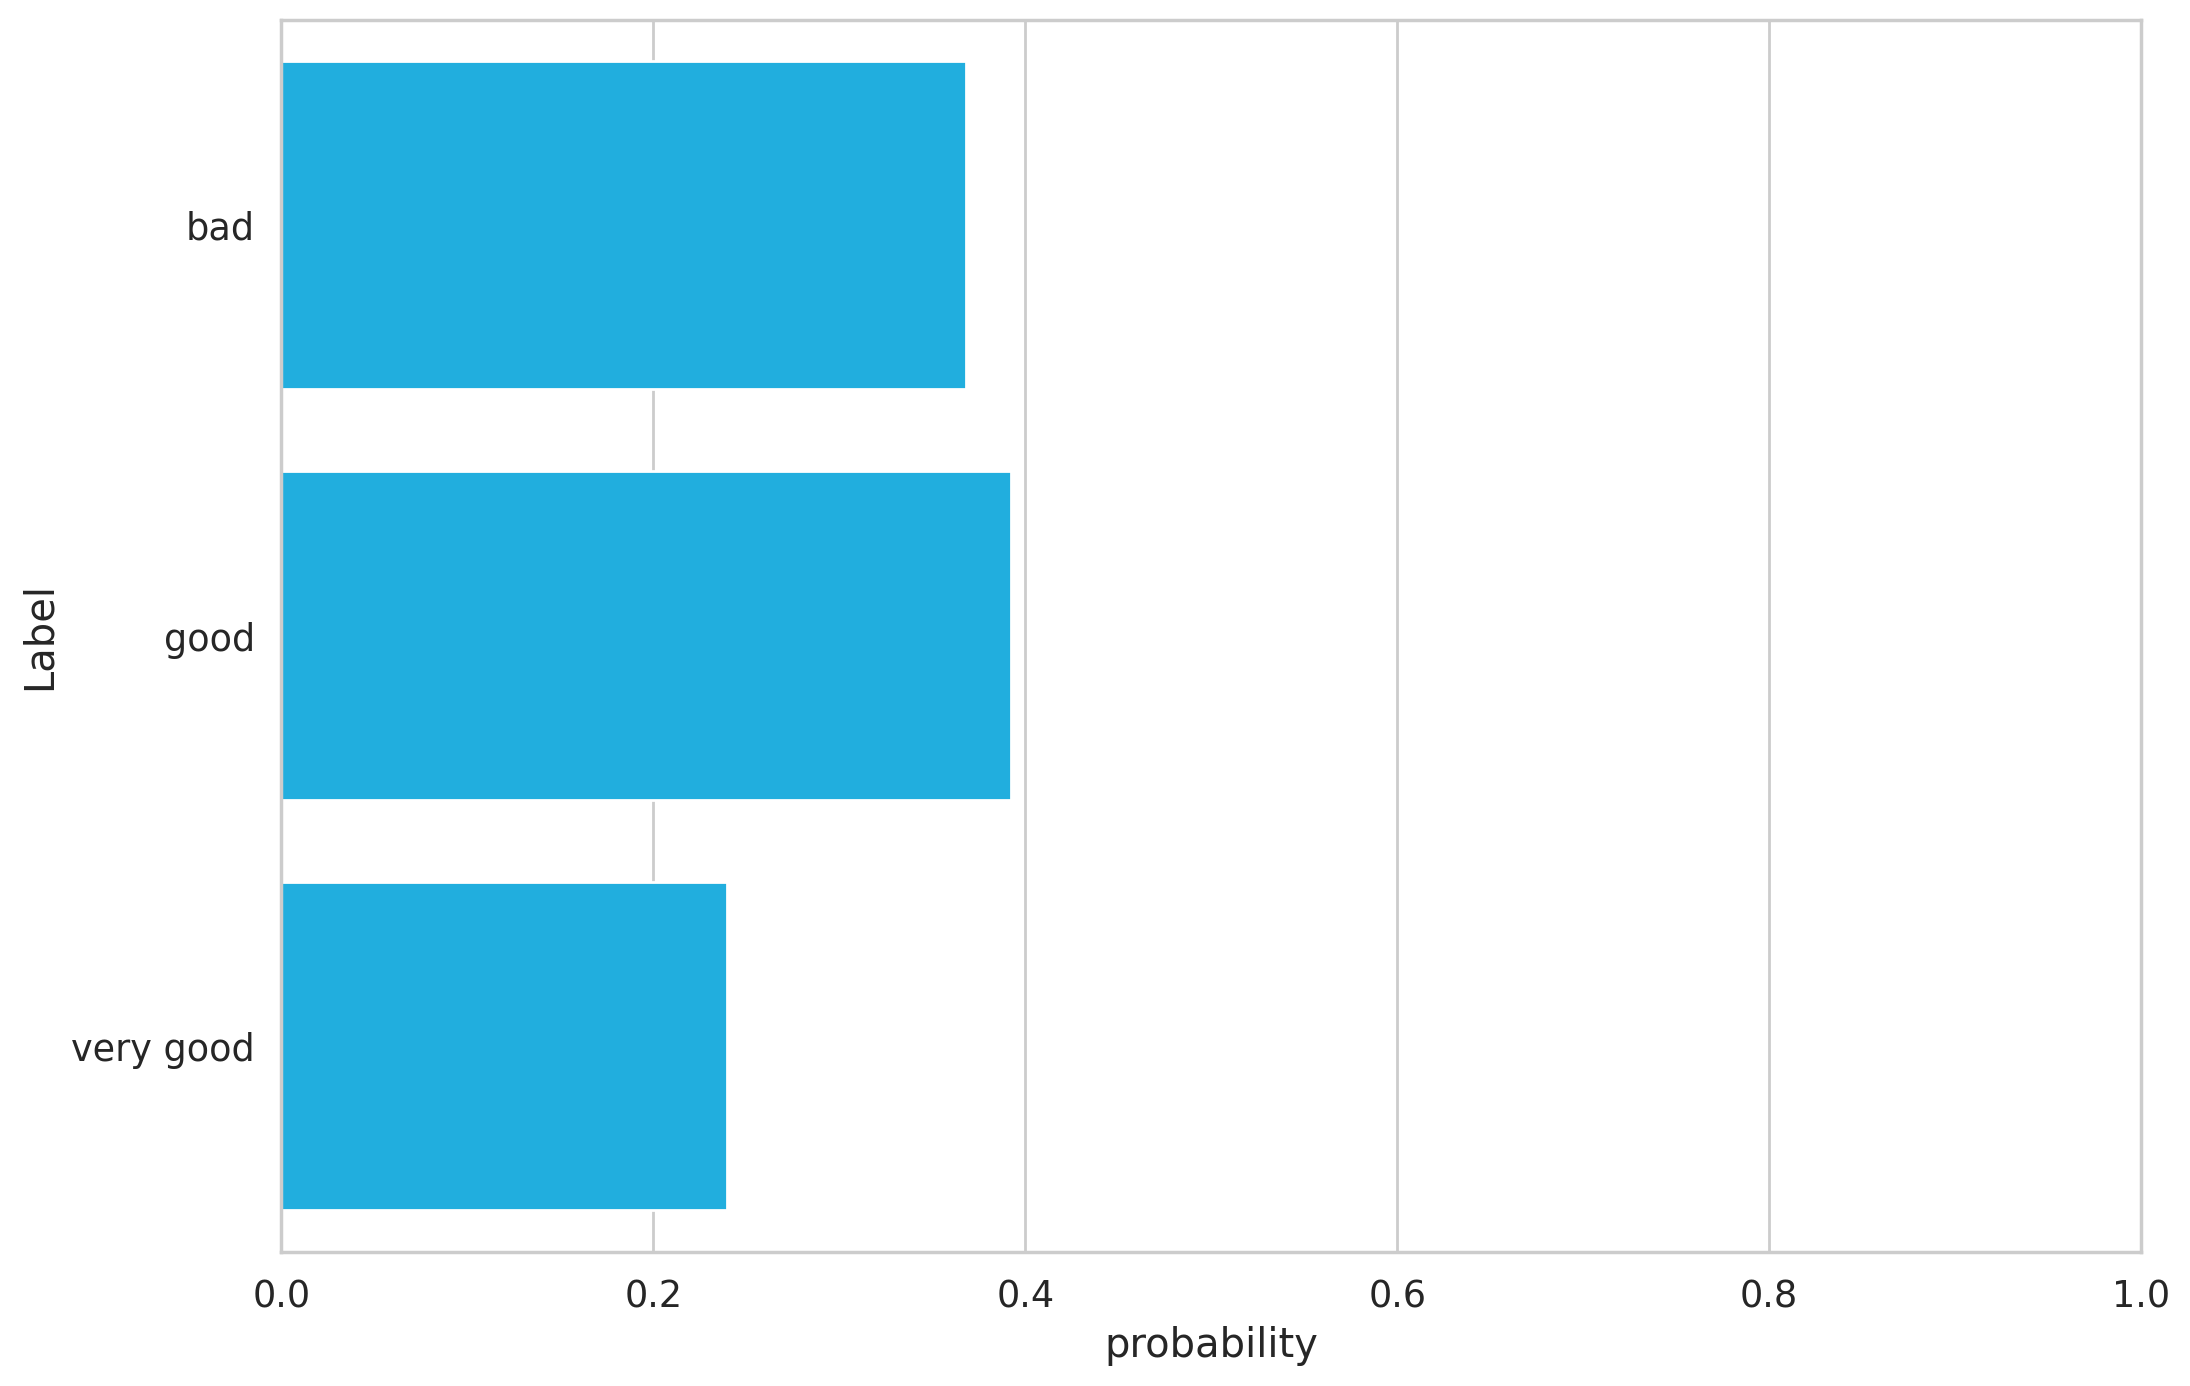

In [89]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Label')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [90]:
Raw_Text = "শুধু একটা মাউন্টেইন ডিউ চেয়ে ছিলাম। তারা আমাকে বুঝালো তাদের হিসাবে ঝামেলা হবে তাই দিতে পারছেন না  দিলেও সেটা ১৫মিনিট পর কিন্তু তাদের ফ্রিজ ভরা ড্রিংক্স ছিলো । সব থেকে ভালো লাগলো তারা খুব সুন্দর ভাবে হাসিমুখে কাস্টমার দের ইগ্নর করতে পারে। আমি তাই আর কথা না বারিয়ে বের হয়ে পরলাম। "

In [91]:
encoded_review = tokenizer.encode_plus(
  Raw_Text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [92]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Raw Text: {Raw_Text}')
print(f'Prediction  : {class_names[prediction]}')

Raw Text: শুধু একটা মাউন্টেইন ডিউ চেয়ে ছিলাম। তারা আমাকে বুঝালো তাদের হিসাবে ঝামেলা হবে তাই দিতে পারছেন না  দিলেও সেটা ১৫মিনিট পর কিন্তু তাদের ফ্রিজ ভরা ড্রিংক্স ছিলো । সব থেকে ভালো লাগলো তারা খুব সুন্দর ভাবে হাসিমুখে কাস্টমার দের ইগ্নর করতে পারে। আমি তাই আর কথা না বারিয়ে বের হয়ে পরলাম। 
Prediction  : good
